In [2]:
# import fastai
from fastai.vision.all import *

In [3]:
import os
from dotenv import load_dotenv
load_dotenv() 
# Path to dataset
path = Path(os.getenv("DATASET_PATH"))

# DataLoaders with built-in augmentation
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,       # 80/20 split
    seed=42,             # reproducibility
    bs=32,               # batch size
    item_tfms=Resize(460, method=ResizeMethod.Squish, pad_mode='zeros'),  # resize before augmentation
    batch_tfms=[
        *aug_transforms(  # fastai's smart augmentations
            size= 224,
            do_flip=True,
            flip_vert=False,
            max_rotate=10,
            max_zoom=1.1,
            min_scale=0.9,
            max_warp=0.05,
            p_affine=0.5,
            p_lighting=0.7
            
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
)

In [5]:
learn = vision_learner(
    dls,
    resnet34,
    metrics=accuracy,
    loss_func=CrossEntropyLossFlat(),
    opt_func=SGD
)


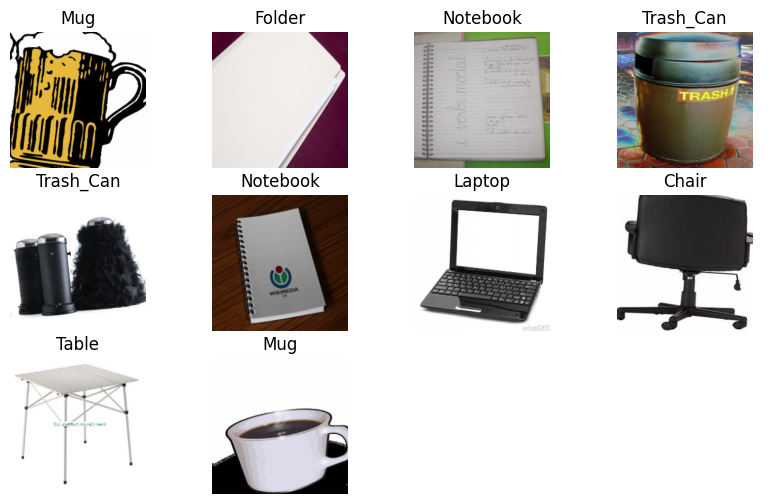

In [4]:
dls.show_batch(max_n=10, figsize=(10,6))

In [6]:
# print classes
print(dls.vocab)

['Backpack', 'Chair', 'File_Cabinet', 'Folder', 'Laptop', 'Mug', 'Notebook', 'Pen', 'Table', 'Trash_Can']


SuggestedLRs(valley=0.007585775572806597)

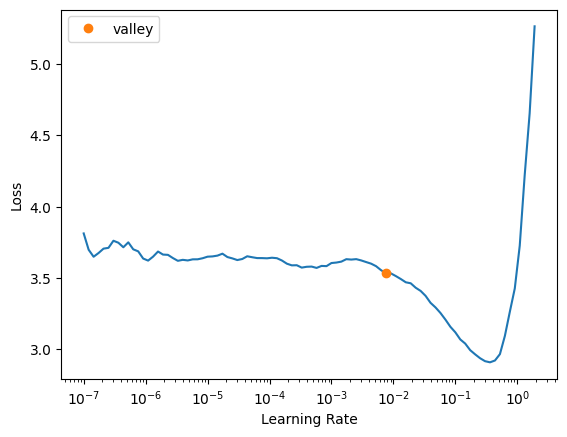

In [7]:
# Find learning rate
learn.lr_find()

Take the learning rate before the loss sharply increases so, taking learning rate of 1e-2

In [8]:
# freeze petrained layers
learn.freeze()

# train head for r epoch with learning rate of 1e-2
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.680745,1.040828,0.688679,07:23
1,1.391416,0.468689,0.854717,09:08
2,0.896039,0.383127,0.879245,09:27
3,0.692181,0.354044,0.884906,11:09
4,0.647780,0.359147,0.881132,10:05


SuggestedLRs(valley=0.0030199517495930195)

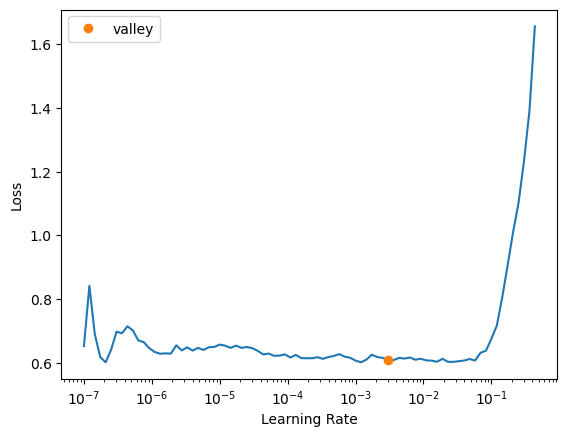

In [9]:
#unfreeze model and find learning rate
learn.unfreeze()
learn.lr_find()


The learning rate range is (1e-5, 3e-3)

In [10]:
# import callback
from fastai.callback.all import *
early_stop = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=3)

In [11]:
#fine tune the entire model
learn.fit_one_cycle(8, lr_max=slice(1e-5,3e-3), cbs=[early_stop])

epoch,train_loss,valid_loss,accuracy,time
0,0.576808,0.361664,0.890566,06:45
1,0.569064,0.337846,0.896226,06:29
2,0.530787,0.332140,0.892453,06:59
3,0.530208,0.317412,0.898113,07:29
4,0.499945,0.318315,0.898113,06:16
5,0.486258,0.311638,0.888679,06:19
6,0.460860,0.312536,0.898113,06:18
7,0.479159,0.311062,0.903774,06:14


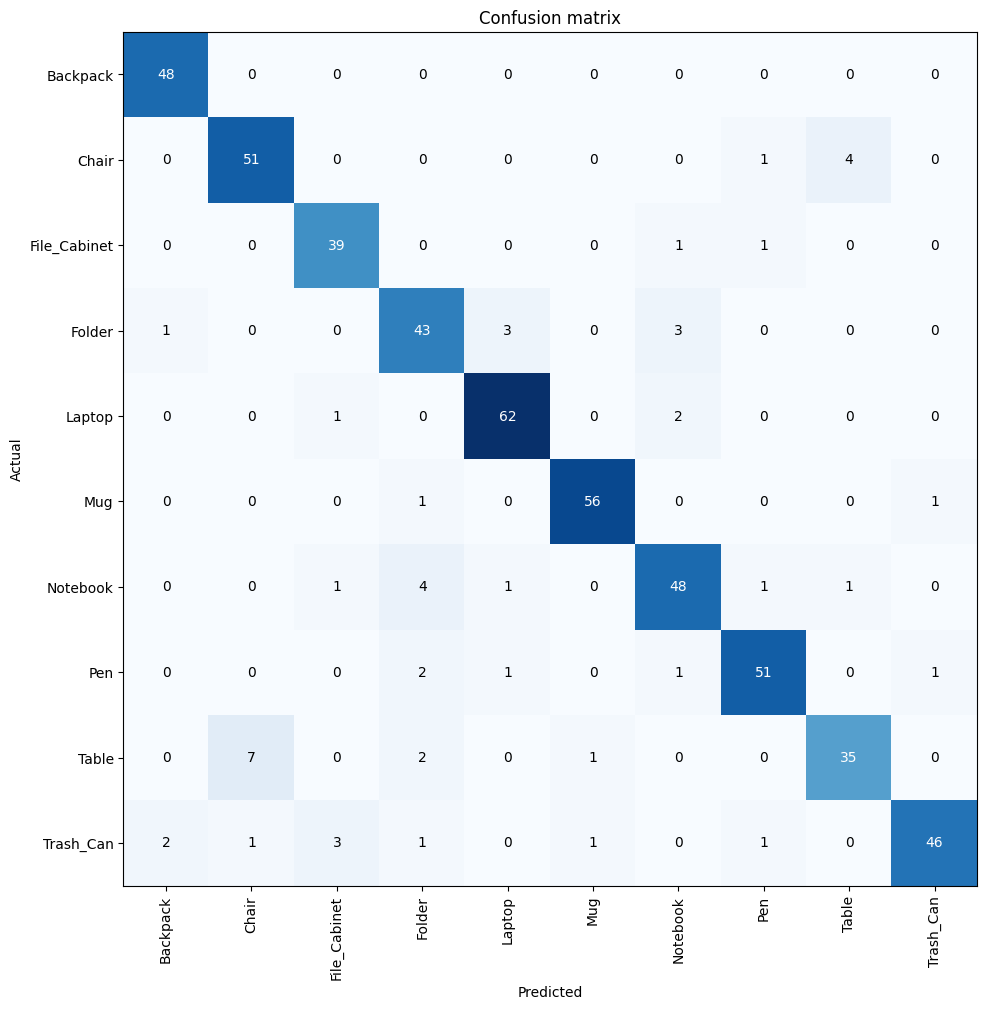

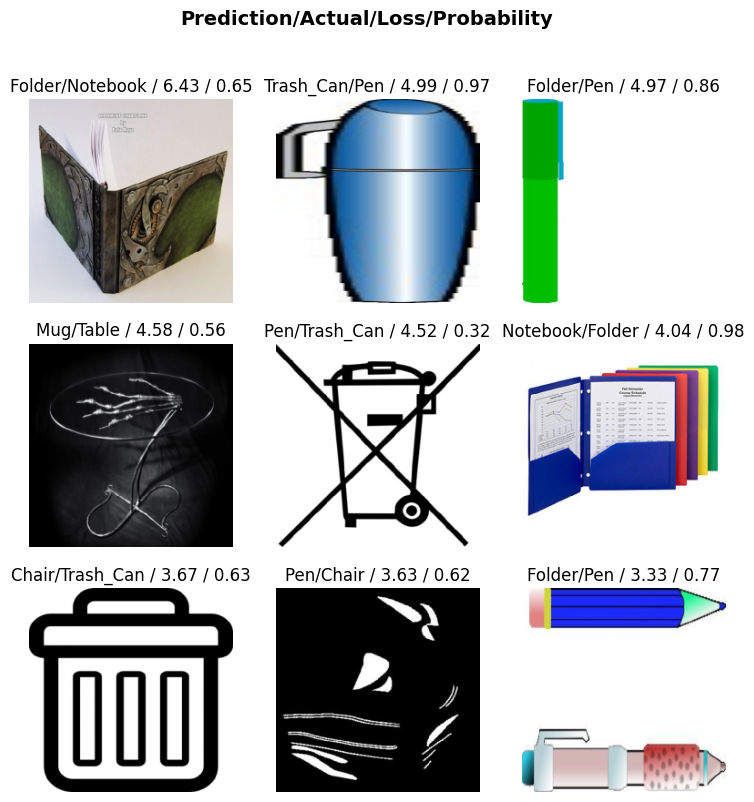

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))
interp.plot_top_losses(9, nrows=3)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np

# Get predictions
preds, targs = learn.get_preds()

# Convert probabilities to class indices
pred_classes = preds.argmax(dim=1)
true_classes = targs

# Get class labels
labels = learn.dls.vocab

# Compute metrics
f1 = f1_score(true_classes, pred_classes, average='weighted')
precision = precision_score(true_classes, pred_classes, average='weighted')
recall = recall_score(true_classes, pred_classes, average='weighted')
cm = confusion_matrix(true_classes, pred_classes)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


F1 Score: 0.9032521831401648
Precision: 0.9047599700767678
Recall: 0.9037735849056604
